# MaldiAMRKit guide

### Import `maldiamrkit`

In [1]:
from maldiamrkit.spectrum import MaldiSpectrum
from maldiamrkit.dataset import MaldiSet
from maldiamrkit.preprocessing import PreprocessingConfig
from maldiamrkit.peak_detector import MaldiPeakDetector

### Visualize `PreprocessingConfig`'s default parameters 

In [2]:
default_cfg = PreprocessingConfig()
default_cfg.as_dict()

{'trim_from': 2000,
 'trim_to': 20000,
 'savgol_window': 20,
 'savgol_poly': 2,
 'baseline_half_window': 40}

### `MaldiSpectrum` preprocessing and plot

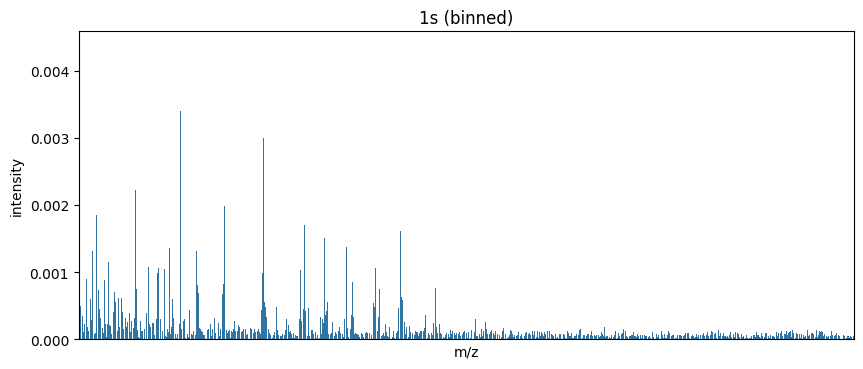

In [3]:
# smoothing, baseline removal, normalisation
spec = MaldiSpectrum(
    "../data/1s.txt"
).preprocess()
# [optional] bin width 3 Da
spec.bin(3)
# plot
_ = spec.plot(binned=True)

Eventually you can activate messages

In [4]:
spec = MaldiSpectrum(
    "../data/1s.txt",
    verbose=True
).preprocess()
spec.bin(3).binned

INFO: Preprocessed spectrum 1s
INFO: Binned spectrum 1s (w=3)


,mass,intensity
0,2000,0.000039
1,2003,0.000041
2,2006,0.000083
3,2009,0.000123
4,2012,0.000109
...,...,...
5995,19985,0.000087
5996,19988,0.000054
5997,19991,0.000048
5998,19994,0.000050


Skipping binning

INFO: Preprocessed spectrum 1s


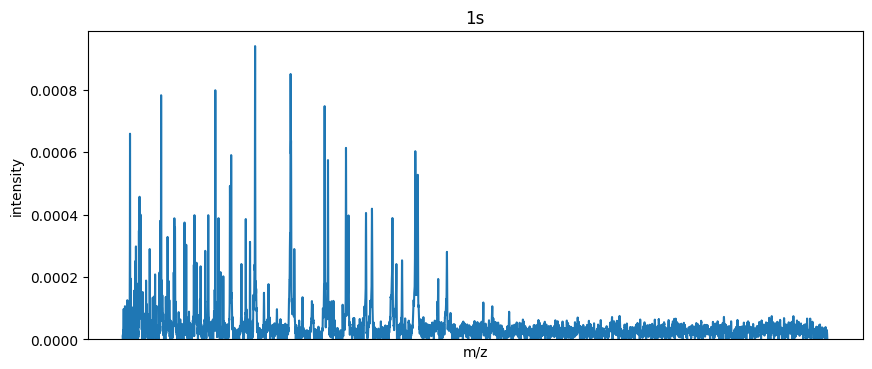

In [5]:
spec = MaldiSpectrum(
    "../data/1s.txt",
    verbose=True
).preprocess()
_ = spec.plot(binned=False)

### Build the `MaldiSet` dataset from a directory containing raw spectra

In [6]:
data = MaldiSet.from_directory(
    "../data/",
    "../data/metadata/metadata.csv",
    aggregate_by=dict(antibiotic="Drug"),
)
X, y = data.X, data.y

X.shape, y.shape

((29, 6000), (29,))

In [7]:
y.head()

22s    R
6s     S
28s    S
5s     S
19s    S
Name: Drug, dtype: object

In [8]:
y = y.map({
    "S": 0,
    "I": 1,
    "R": 1
})
y.head()

22s    1
6s     0
28s    0
5s     0
19s    0
Name: Drug, dtype: int64

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ("peaks", MaldiPeakDetector(binary=False, prominence=1e-7)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression())
])
pipe.fit(X, y)

,steps,"[('peaks', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,binary,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001


In [10]:
pipe.score(X,y)

1.0